# Here we prepare/convert data for FT with Aleph-Alpha text2Signal use-case
examples taken from:

https://github.com/samlhuillier/viggo-finetune/blob/main/openai/openai_dataset_analytics.ipynb

In [1]:
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import sys
import os
sys.path.append("./")
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

# II. read and prepare data for FT with openAI


```json
[
    {
        "prompt": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nList four animals that are indigenous to the continent in the input.\n\n### Input:\nAfrika\n\n### Response:",
        "completion": "1. lion\n2. zebra\n3. giraffe\n4. crocodile"
    },
    {
        "prompt": "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWrite a haiku mentioning a forest.\n\n### Response:",
        "completion": "Over the wintry\n\nForest, winds howl in rage\n\nWith no leaves to blow"
    }
]
### Prompt use in code-llama FT experiments:

```yaml
query_template: >
<s>[INST]
You are SIGNAL assistant, a part of SAP Signavio's Process Intelligence Suite. 
SIGNAL stands for Signavio Analytics Language. 
SIGNAL is a dialect of SQL.
Your goal is to help users craft SIGNAL 
queries and understand the SIGNAL language better. 
### Instruction:
Task to solve:
Construct SIGNAL expression querying given textual description in Input.
Expected output results are in JSON format.
### Input:
{description_llm}
### Output:
[/INST]
response_template: >
{{ "query":"""{query}"""}}</s>

```


In [16]:
import json

file_path='text2signal_train_5715.jsonl'
#file_path='text2signal_train_5715_openai.jsonl'
file_path="text2signal_test_1000.jsonl"
dataset_in = []
with open(file_path) as f:
    for line in f:
        dataset_in.append(json.loads(line))
dataset_in[10]#['filename']

{'filename': 'e21acbeec8',
 'split': 'test',
 'name': '_Total approved hours',
 'query': '\nSELECT\nSUM("TSR_HoursApproved")\nFROM "defaultview-197"\n                ',
 'llm_name': 'signal_description_llama2-70b-chat-hf',
 'description_llm': "Retrieve the sum of the 'TSR_HoursApproved' column from the 'defaultview-197' table."}

In [5]:
def system_message(descriptionllm):
    return """You are SIGNAL assistant, a part of SAP Signavio's Process Intelligence Suite. 
SIGNAL stands for Signavio Analytics Language. 
SIGNAL is a dialect of SQL.
Your goal is to help users craft SIGNAL queries and understand the SIGNAL language better. 
### Instruction:
Task to solve:
Construct SIGNAL expression querying given textual description in Input.
Expected output results are in JSON format.
### Input:
{}
### Output:
""".format(descriptionllm)

template= {
        "prompt": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nList four animals that are indigenous to the continent in the input.\n\n### Input:\nAfrika\n\n### Response:",
        "completion": "1. lion\n2. zebra\n3. giraffe\n4. crocodile"
    }
system_message("jjkkjlkj")

"You are SIGNAL assistant, a part of SAP Signavio's Process Intelligence Suite. \nSIGNAL stands for Signavio Analytics Language. \nSIGNAL is a dialect of SQL.\nYour goal is to help users craft SIGNAL queries and understand the SIGNAL language better. \n### Instruction:\nTask to solve:\nConstruct SIGNAL expression querying given textual description in Input.\nExpected output results are in JSON format.\n### Input:\njjkkjlkj\n### Output:\n"

In [17]:
dataset=[]
for el in dataset_in: #[:3]:
    query= {"prompt": f'{system_message(el["description_llm"])}', 
        "completion": f'{el["query"]}'} 
              
    #print(query)
    dataset.append(query)

len(dataset), dataset[2]



(1000,
 {'prompt': "You are SIGNAL assistant, a part of SAP Signavio's Process Intelligence Suite. \nSIGNAL stands for Signavio Analytics Language. \nSIGNAL is a dialect of SQL.\nYour goal is to help users craft SIGNAL queries and understand the SIGNAL language better. \n### Instruction:\nTask to solve:\nConstruct SIGNAL expression querying given textual description in Input.\nExpected output results are in JSON format.\n### Input:\nGet the percentage of rejected PO items that are catalog items. Filter the results by 'Last Invoice Id' and calculate the percentage by dividing the count of distinct 'Last Invoice Id' for rejected PO items by the total count of distinct 'Last Invoice Id'.\n### Output:\n",
  'completion': 'SELECT count(distinct "Last Invoice Id" ) \nFILTER (WHERE "PO Confirmation Status"  = \'Rejected\'\nAND "PO Item Line Type" = \'Catalog\')/\ncount(distinct "Last Invoice Id" ) * 100\nFROM "defaultview-431"'})

In [10]:
len(dataset)

1000

In [14]:
## Save JSONL in openAI format
file_path="text2signal_test_1000_aa.jsonl"
file_path='text2signal_train_5715_aa.jsonl'
#file_path='text2signal_train_5715_openai.jsonl'
with open(file_path, 'w') as outfile:
    for entry in dataset:
        json.dump(entry, outfile)
        outfile.write('\n')

In [18]:
file_path="text2signal_test_1000_aa.json"
#file_path='text2signal_train_5715_aa.json'
#file_path='text2signal_train_5715_openai.jsonl'
with open(file_path, 'w') as outfile:
        json.dump(dataset, outfile)

# Read Logs from AA training

In [149]:
import pandas as pd
import datetime
file_path="log_RANK 0.log"
ft_results = []
with open(file_path) as f:
    for line in f:
        if '[INFO] [RANK 0] {"training/loss":' in line:
            l=line.split('[INFO] [RANK 0] ')[1].split("}")[0]+"}"
            tm="["+line.split('[INFO] [RANK 0] ')[0].split("[")[2].strip()
            #t=#format='%Y-%m-%d %H:%M:%S.%f'
            #print(tm)
            #print(datetime.datetime.strptime(str(tm), "[%Y-%m-%d %H:%M:%S,%f]"))
            r = json.loads(l)
            r["timestamp"]=datetime.datetime.strptime(str(tm), "[%Y-%m-%d %H:%M:%S,%f]")
            ft_results.append(r)
    ft_res = pd.DataFrame.from_dict(ft_results)
ft_res.columns

Index(['training/loss', 'runtime/step_duration', 'runtime/tflops_megatron',
       'runtime/tflops_megatron_layout_independent', 'runtime/tflops_bloom',
       'runtime/tflops_electra', 'runtime/tflops_aleph_alpha',
       'runtime/mfu_palm', 'training/global_grad_norm',
       'training/learning_rate_weight_decay_params', 'accuracy', 'timestamp',
       'evaluation/accuracy', 'evaluation/loss', 'evaluation/step_duration'],
      dtype='object')

In [160]:
ft_res[ft_res['evaluation/accuracy'].notnull()][["timestamp",'training/loss','accuracy','evaluation/accuracy']].sort_values(by=['evaluation/accuracy'], ascending=False)
#ft_res[["timestamp",'training/loss','accuracy','evaluation/accuracy']].value_counts

,timestamp,training/loss,accuracy,evaluation/accuracy
4099,2024-01-25 10:28:28.580,0.009567,0.999365,0.990533
3199,2024-01-25 01:12:29.005,0.008234,0.995258,0.986910
1899,2024-01-24 11:48:05.198,0.020313,0.992844,0.982844
2499,2024-01-24 17:58:44.892,0.017464,0.996156,0.982100
1299,2024-01-24 05:38:10.361,0.043743,0.990587,0.980650
4499,2024-01-25 14:35:51.398,0.012231,0.985037,0.979404
3699,2024-01-25 06:21:17.688,0.008285,0.994681,0.979206
2099,2024-01-24 13:51:21.294,0.013206,0.998637,0.973737
1599,2024-01-24 08:43:13.986,0.028879,0.986721,0.969901
2299,2024-01-24 15:55:01.085,0.012288,1.000000,0.967858


In [161]:
#ft_res[ft_res['evaluation/accuracy'].notnull()].reset_index().sort_values(by=['evaluation/accuracy'], ascending=True)

<Axes: title={'center': 'evaluation/accuracy'}, xlabel='index'>

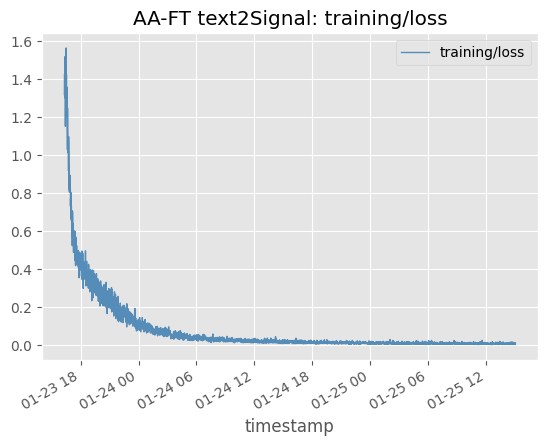

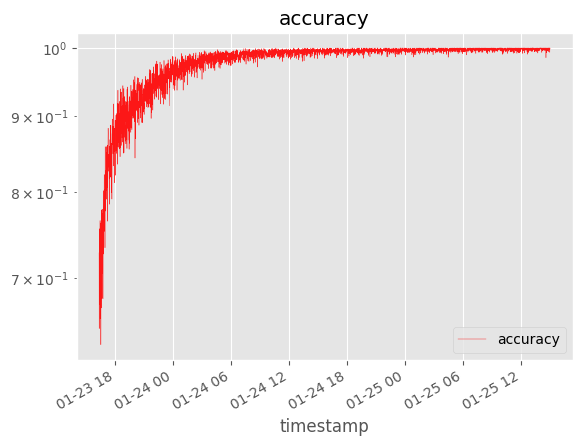

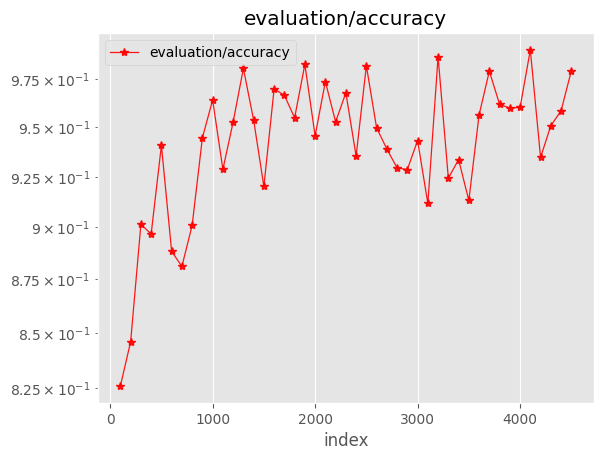

In [154]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
col='training/loss'
cx='index'
cx='timestamp'
ft_res.reset_index().plot(x=cx, y=col, logy=False, linewidth=1,  alpha=0.9,  color='steelblue',title=f"AA-FT text2Signal: {col}" )
col='accuracy' #'evaluation/loss'
ft_res.reset_index().plot(x=cx,y=col, logy=True, linewidth=0.3,  alpha=0.9,  color='red',title=f"{col}" )
col='evaluation/accuracy'
cx='index'
ft_res[ft_res['evaluation/accuracy'].notnull()].reset_index().plot(x=cx,y=col, logy=True, linewidth=0.9, style='*-',  alpha=0.9,  color='red',title=f"{col}" )
